# Regression with an Abalone Dataset


### Description du jeu de données : 

- L'ensemble de données pour cette compétition (à la fois pour la formation et le test) a été généré à partir d'un modèle d'apprentissage profond formé sur l'ensemble de données Abalone. Les distributions des caractéristiques sont proches, mais pas exactement les mêmes, que celles de l'original. 

- **Votre objectif** : L'objectif de ce concours est de prédire l'âge des ormeaux à partir de diverses mesures physiques


Disponible sur : https://www.kaggle.com/competitions/playground-series-s4e4/overview

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line


In [229]:
### Imports 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import missingno as msno


#test statistique : 
from scipy.stats import spearmanr, kendalltau,pearsonr, shapiro,kruskal

#import outils reductions dimensions
from sklearn.decomposition import PCA #linéaire
from sklearn.manifold import TSNE #non linéaire pour structure locale




#package modele non supervisé
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer #permet tracer courbe pour choisir bonne valeur KMeans
from sklearn.cluster import KMeans



import os
import warnings
warnings.filterwarnings("ignore")

# Plan : 

#### 1. Connaissance du jeu de données 
- Présence d'une target ?
- Que signifie les features
- Dimensions des données
- Type de données et cohérence (variables discrètes : int, continues : float, qualitative : str)
- Présence de données manquantes ? 

#### 2. Analyse univariée
- Target
- Variables continues
- Variables qualitatives

#### 3. Analyse bivariées & test statistiques
- Target Vs numériques continues 
- Target Vs catégoriques (discrètes + qualitatives)


#### 4. analyse multivariée


In [324]:
path = r"D:\\Etude_Data_science\\Kaggle_competition\\05_Regression_with_an_Abalone_Dataset\\datasets\\"

In [411]:
data = pd.read_csv(path+"train.csv")
df = data.copy()

In [412]:
df.shape

(90615, 10)

In [17]:
df.head()

,id,Sex,Length,Diameter,Height,Whole weight,Whole weight.1,Whole weight.2,Shell weight,Rings
0,0,F,0.550,0.430,0.150,0.7715,0.3285,0.1465,0.2400,11
1,1,F,0.630,0.490,0.145,1.1300,0.4580,0.2765,0.3200,11
2,2,I,0.160,0.110,0.025,0.0210,0.0055,0.0030,0.0050,6
3,3,M,0.595,0.475,0.150,0.9145,0.3755,0.2055,0.2500,10
4,4,I,0.555,0.425,0.130,0.7820,0.3695,0.1600,0.1975,9


* **Abalone** = mollusque, pour lesquels on va avoir différents paramètres mesurés.
- Features :
- id; pour identifier l'individu
- Sex, Length, Diameter, Height sont des paramètres sur la taille de l'individus et son sexe
- Whole weight.1/2 sont les poids totaux
- Shell weight : pids de la coque
- **Rings** : anneaux, c'est **la target a prédire**, et elle est de type **integer** ( on peut supposer discrète)

#### Kaggle evaluera les performances du modèle avec la RMSLE (Root Mean Squared Logarithmic Error) donc on peut considérer la target comme un problème de régression avec des données positives ou nulles (mais non négatives)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90615 entries, 0 to 90614
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              90615 non-null  int64  
 1   Sex             90615 non-null  object 
 2   Length          90615 non-null  float64
 3   Diameter        90615 non-null  float64
 4   Height          90615 non-null  float64
 5   Whole weight    90615 non-null  float64
 6   Whole weight.1  90615 non-null  float64
 7   Whole weight.2  90615 non-null  float64
 8   Shell weight    90615 non-null  float64
 9   Rings           90615 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 6.9+ MB


Concernant le reste des infos, il y a une cohérence entre le dtype d'une feature et la feature elle même 
- integer pour des variables quantitatives discrètes,
- object pour variable qualitative 
- float pour des variables quantitatives continues

* On notera par la même occasion qu'il **n'y a pas de données manquantes donc pas besoin d'imputation**

# 2. Analyse univariée
#### Séparation des données en fonction du type de variable

In [25]:
#Retirons l'id car nous n'allons pas l'analyser :
identifiant = df.id
df = df.drop("id", axis = 1)

In [171]:
#Séparons les données 
var_dis = list(df.select_dtypes(int).columns)
var_cont = list(df.select_dtypes([float,int]))
var_qual = list(df.select_dtypes(object))

### 2.1 target
- Nous avons vu dans la section précédente que le type de donnée était cohérent avec la feature elle même, donc on peut facilement séparer les types de données

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

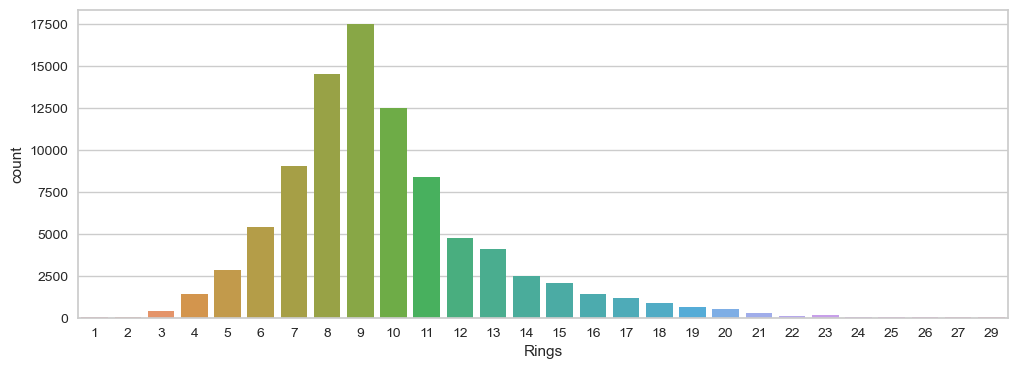

Mean : 9.7
Mode : 9


In [180]:
plt.figure(figsize=(12,4))
sns.countplot(data = df, x = "Rings" )
plt.show()
print("Mean :",round(df["Rings"].mean(),2))
print("Mode :",df.Rings.mode()[0])

#### Attention, ici on considère cette variable comme continue

* On voit très clairement ici que notre target suit une loi de distribution normale, avec un mode de 9 anneaux et une moyenne de 9.7
* La gamme s'étend de 1 anneau à 29

### 2.2 Variables continues
- Visualisation
- Observation % outliers + skew
- Test normalité


In [173]:
def outlier(col):
    """Fonction qui calcul % d'outliers d'une colonne donnée"""
    q1 = col.quantile(0.25) 
    q3 = col.quantile(0.75) 
    iqr = q3 - q1
    lim_inf = q1 - 1.5*iqr
    lim_sup = q3 + 1.5 * iqr
    n_outlier = ((col<lim_inf) | (col> lim_sup)).sum()
    pourcent_outlier = (n_outlier/len(col))*100
    return round(pourcent_outlier,2)

In [174]:
print(var_cont)
print("Il y a", len(var_cont), "features à analyser ")

['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']
Il y a 8 features à analyser 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

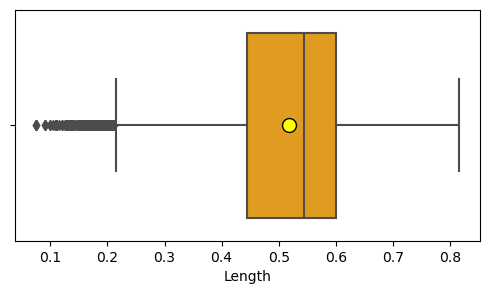

In [306]:
plt.figure(figsize=(6,3))
ax = sns.boxplot(data = df[var_cont], x = "Length", 
                    color = "orange", showmeans=True, 
                     meanprops={"marker": "o", 
                                "markeredgecolor": "black",
                                "markerfacecolor":"yellow", 
                                "markersize": "10", 
                                "label":"mean"} )

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

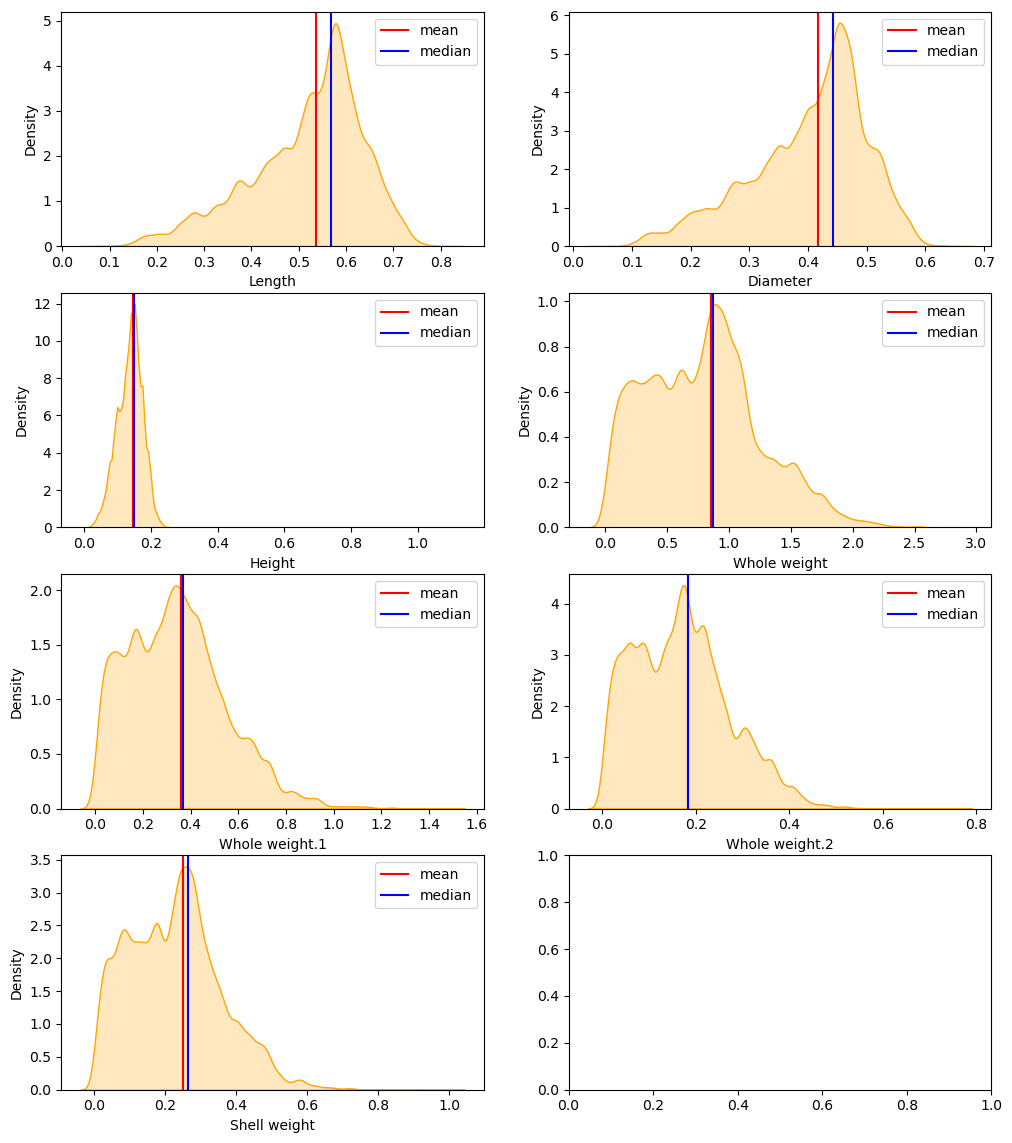

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

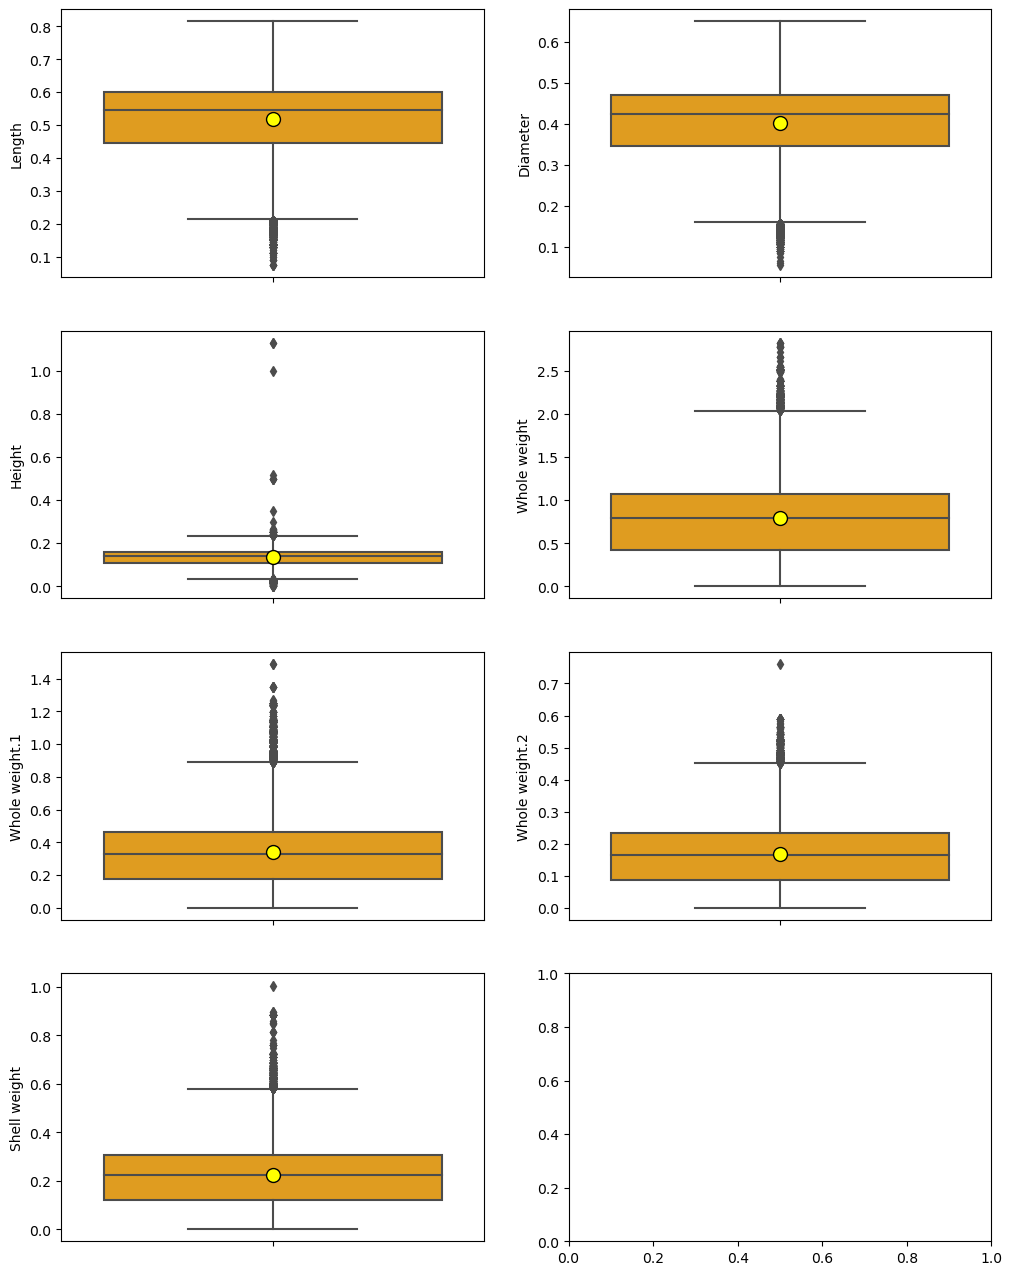

In [297]:
#On va créer un subplot de dimension (2,4) pour analyser toutes ces variables
fig, axes = plt.subplots(4,2, figsize=(12,14)) #2 lignes et 4 colonnes

for i,k in enumerate(var_cont):
    nrow,ncol = i//2 , i%2
    ax = sns.kdeplot(data = df[k], ax = axes[nrow,ncol], fill=True,
                    color = "orange")
    ax.axvline(df[k].sample(100,random_state= 42).mean(), label = "mean", c = "red")
    ax.axvline(df[k].sample(100,random_state= 42).median(), label = "median", c = "blue")


    ax.legend()
plt.show()
 
#On va créer un subplot de dimension (2,4) pour analyser toutes ces variables
fig, axes = plt.subplots(4,2, figsize=(12,16)) #2 lignes et 4 colonnes

for i,k in enumerate(var_cont):
    nrow,ncol = i//2 , i%2
    ax = sns.boxplot(data = df[var_cont], y = k, ax = axes[nrow,ncol], 
                    color = "orange", showmeans=True, 
                     meanprops={"marker": "o", 
                                "markeredgecolor": "black",
                                "markerfacecolor":"yellow", 
                                "markersize": "10", 
                                "label":"mean"} )

plt.show()

In [176]:
print("% Outliers\n")
for col in df[var_cont]:
    print(f"{col:-<18} : {outlier(df[col])} %")

% Outliers

Length------------ : 1.61 %
Diameter---------- : 1.74 %
Height------------ : 0.38 %
Whole weight------ : 0.63 %
Whole weight.1---- : 1.07 %
Whole weight.2---- : 0.49 %
Shell weight------ : 0.74 %
Rings------------- : 6.32 %


In [177]:
print("Skew :\n")
for col in df[var_cont]:
    print(f"{col:-<18} : {(round(df[col].skew(),2))}")

Skew :

Length------------ : -0.73
Diameter---------- : -0.7
Height------------ : 0.31
Whole weight------ : 0.43
Whole weight.1---- : 0.59
Whole weight.2---- : 0.48
Shell weight------ : 0.48
Rings------------- : 1.2


- La moyenne et la médiane sont proches ici pour l'ensemble des valeurs

- L'aspect des courbes (skewness) :
    - Elle traduit la régularité avec laquelle les observations se répartissent autour de la valeur centrale.
    - pour **length et diameter**, la valeur de l'asymétrie est **négative**, ce qui explique les valeurs étalées sur la gauche. Donc il y a plus de chance de rencontrées des individus ayant  des valeurs Length et diameter < à la valeur moyenne empirique.
    - Pour **le reste** des variables les valeurs sont **positives** et indique un étalement sur la droite. Donc plus de chance de retrouver des individus avec des valeurs ayant des valeurs > à la moyenne. 
- Hormis la target Rings, le % d'outliers est inferieur à 5%, donc s'il y avait de l'imputation de données, nous pourrions remplacer par la moyenne plutôt que la médiane 

### Regardons si les variables suivent une loi normale
- Soit l'hypothèse nulle (H0) la variable suit une distribution normale
- Prenons un seuil alpha 5% (cela signifie qu'on accepte un risque de 5% de rejeter l'hypothèse nulle alors qu'elle est vraie)
- Si la pvalue est inférieure à alpha, cela signifie que la probabilité d'observer les données si l'hypothèse nulle est vraie est inférieure à 5%. Dans ce cas, on rejette H0 et on conclut qu'il y a suffisamment de preuves pour suggérer que la variable **ne suit pas une distribution normale.**

In [178]:
var_normal, var_non_normal = [], []
print("P-values\n")
for i in var_cont:
    stat,pval = shapiro(df[i])
    print(f"{i} :  {pval}")
    alpha = 0.05
    if pval<alpha:
        var_non_normal.append(i)
    else:
        var_normal.append(i)
print()
print("Liste des variables suivant une loi normale :", var_normal)
print()
print("Liste des variables ne suivant pas une loi normale :\n", var_non_normal)

P-values

Length :  0.0
Diameter :  0.0
Height :  0.0
Whole weight :  0.0
Whole weight.1 :  0.0
Whole weight.2 :  0.0
Shell weight :  0.0
Rings :  0.0

Liste des variables suivant une loi normale : []

Liste des variables ne suivant pas une loi normale :
 ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight', 'Rings']


* Lors de la partie tests statistiques, nous utiliserons le test de **Mann-Whitney** pour conclure quant à la dépendance ou non des variables continues

### 2.3 Variables qualitatives
- Visualisation

In [208]:
sns.reset_defaults()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

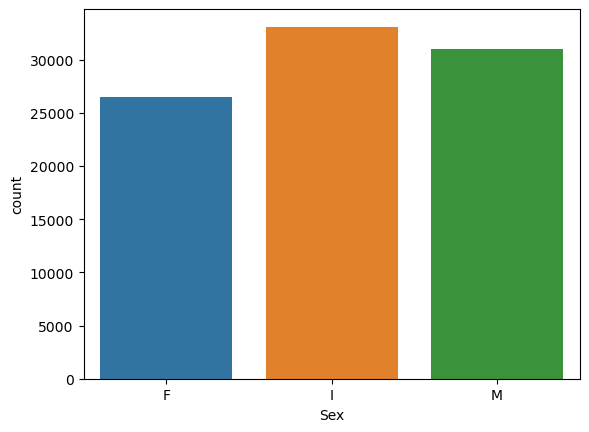

Sex
I    33093
M    31027
F    26495
Name: count, dtype: int64

In [211]:
sns.countplot(data = df[var_qual],  x= "Sex")
plt.show()
df.Sex.value_counts()

- On peut voir ici trois modalités pour le type de sexe :
    - M et F pour respectivement Male et femelles
    - I pour infant, bien que cette espece est binaire, nous avons une séparation des orneaux juvéniles (du fait de leur incapacité à procréé à leur jeune âge ?)

## 3. Analyse bivariées & test statistiques
- **Target vs numérique continues**
    - Heatmap
    - pairplot
    - Test statistique : aucune feature ne suit de loi normale, donc nous allons faire un test de Spearman ou Kendall
        - Si la heatmap et le pairplot montrent une **relation linéaire** : **spearman**
        - Si la heatmap et le pairplot montrent une **relation non linéaire** : **Kendall**
- **Target Vs discrète :**
    - Boxplot
    - Les variables continues ne suivent pas de loi normale : **Test Kruskal-Wallis**



### 3.1 Target vs numériques continues :
#### Heatmap

In [188]:
var_cont.remove("Rings")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

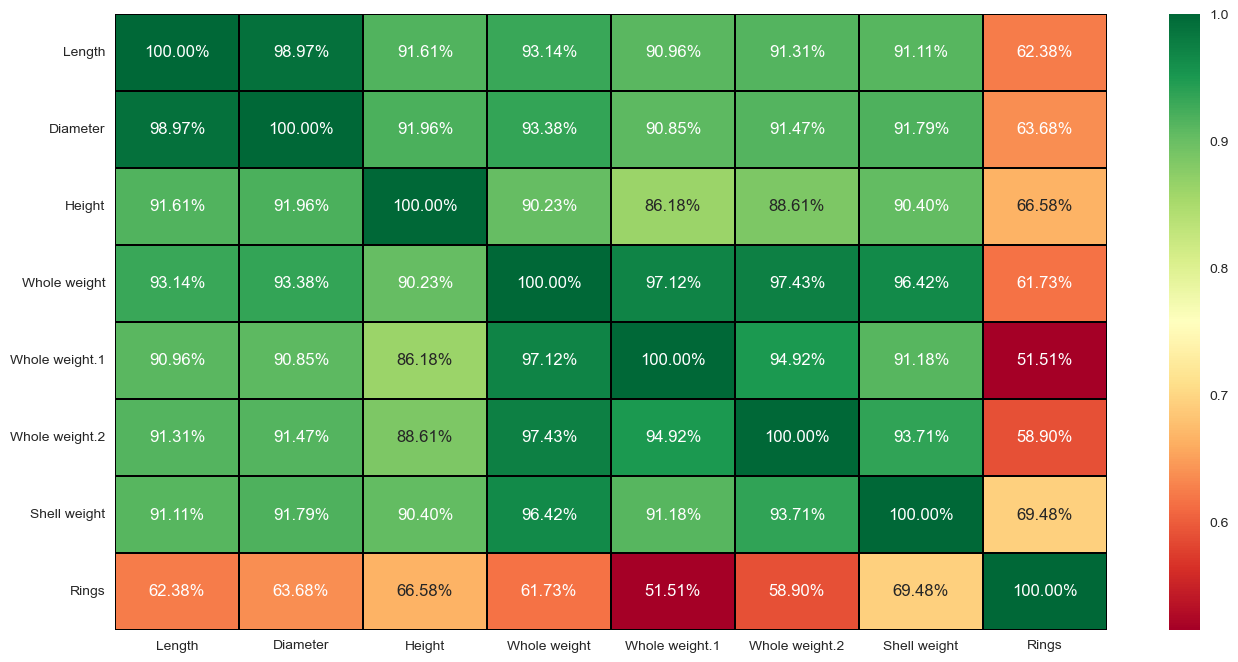

In [206]:
plt.figure(figsize=(16,8))
sns.heatmap(df[var_cont+["Rings"]].corr(),cmap='RdYlGn',fmt=".2%", cbar=True, linewidths=0.2,annot=True,
    linecolor='black')
plt.show()

####  Heatmap target vs variables continues

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

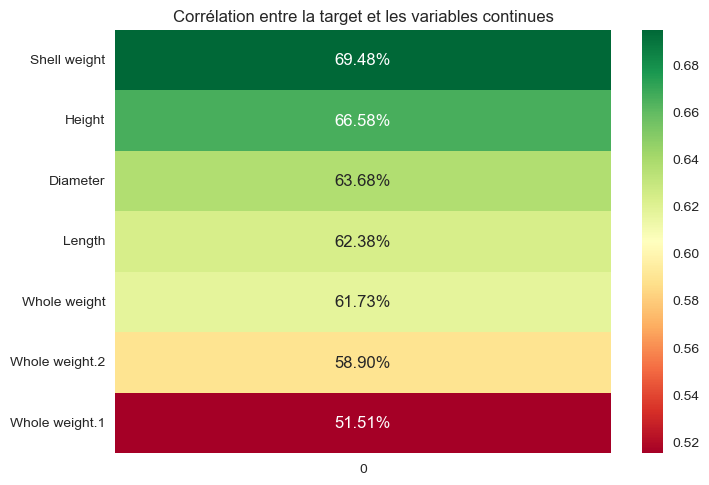

In [189]:
correlation = df[var_cont].corrwith(df['Rings']) #corrwith() permet de calculer la corrélation entre
# Trier les valeurs de corrélation par ordre décroissant
sorted_correlation = correlation.sort_values(ascending=False)
#la target et chaque variable continue
# plt.figure(figsize=(10, 20))
heatmap = sns.heatmap(pd.DataFrame(sorted_correlation), annot=True, cmap='RdYlGn',fmt=".2%", cbar=True)
heatmap.set_title('Corrélation entre la target et les variables continues')
plt.show()

Les deux heatmap montrent qu'il y a énormement de corrélation linéaire entre les variables, peu de surprise à cela, on pouvait s'y attendre, effectivement, plus un ormeau grandit et plus ses caractéristiques physiques augmentent avec l'age (poids , taille, diametre etc)

#### pairplot :

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

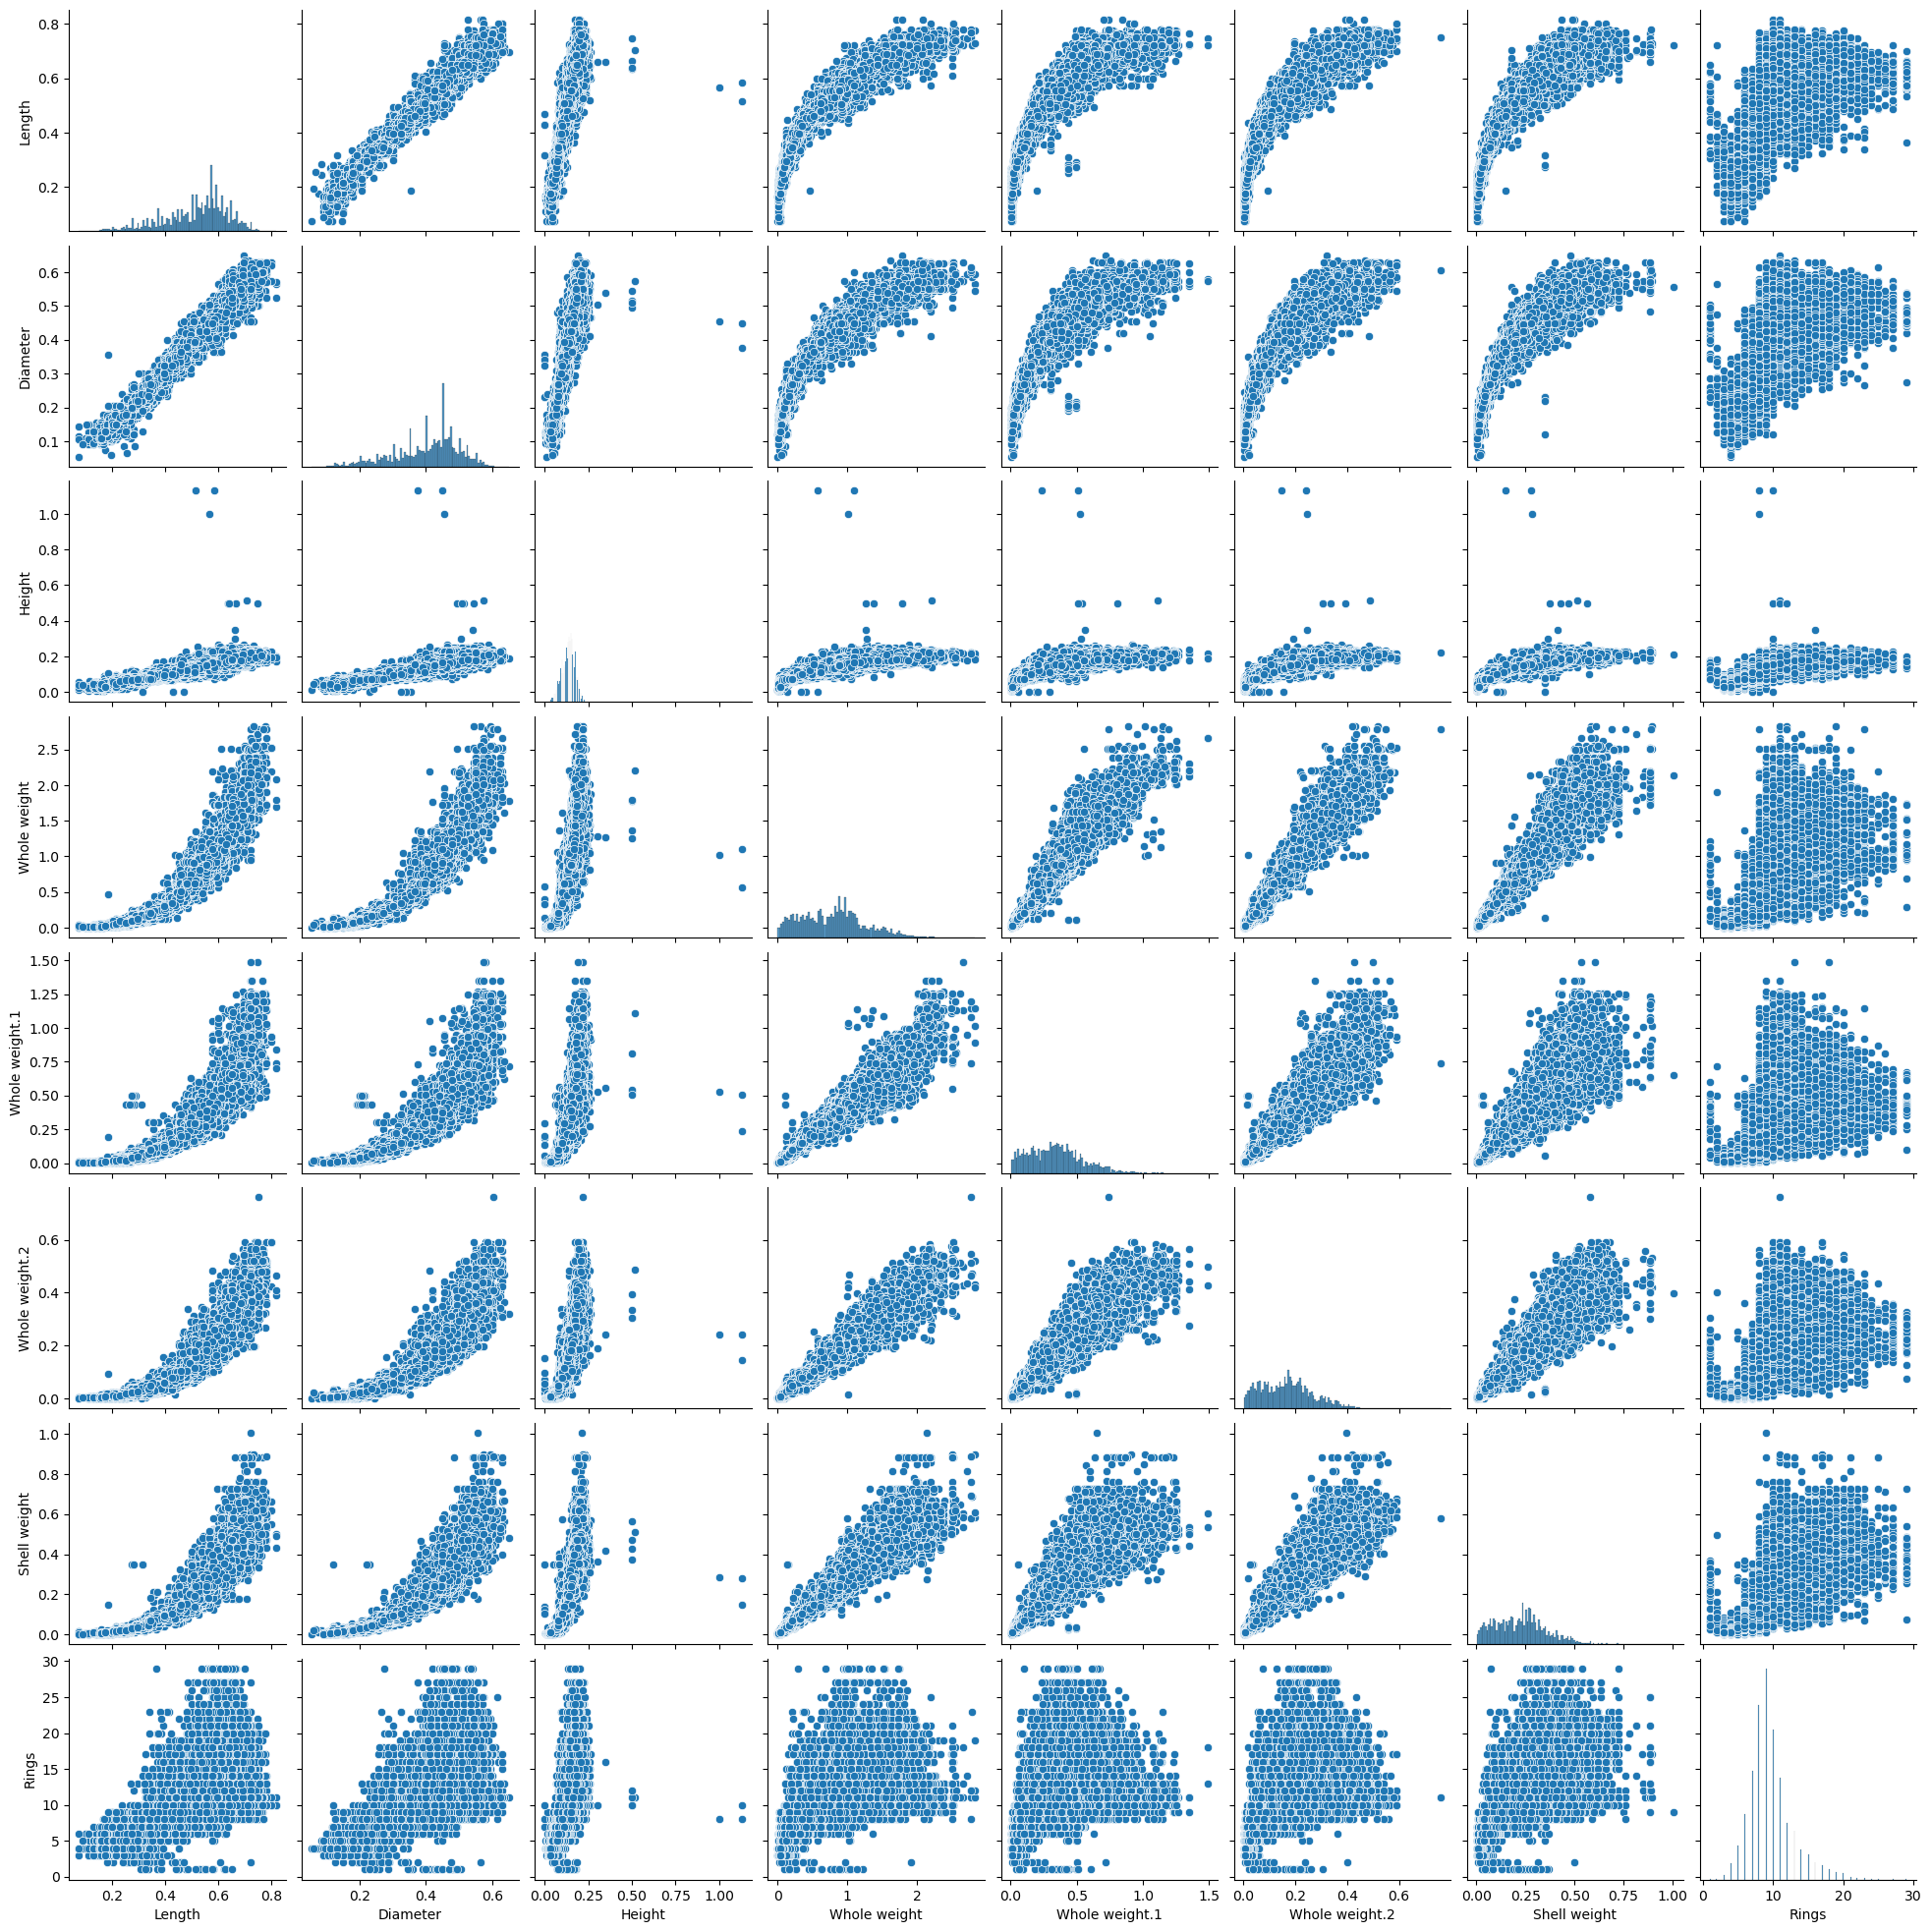

In [292]:
sns.pairplot(data = df[var_cont+["Rings"]])
plt.show()

#### Test de spearman : 


In [288]:
def spearman_test(feature, target, dataframe):
    """
    Fonction pour effectuer le test de corrélation de Spearman entre une feature et une target.
    Paramètres :
        - feature : Liste de features ou une feature unique
        - target : Nom de la target
        - dataframe : DataFrame contenant les données
    
    Retourne :
        - var_a_conserver : Liste des features ayant une corrélation significative avec la target 
        - var_a_suppr: Liste des features n'ayant pas une corrélation significative avec la target
    """
    var_a_conserver = []
    var_a_suppr = []

# Test de corrélation de Spearman
    for feat in feature:
        corr, p_value = spearmanr(dataframe[feat], dataframe [target])

# Afficher les résultats
#         print (f"Feature: {feat}")
#         print (f"Corrélation avec {target} : {corr}")
#         print (f"P-value : {p_value}")

# Interpréter les résultats
        alpha = 0.05 # Niveau de signification
        if p_value < alpha:
            var_a_conserver.append(feat)
        else:
            var_a_suppr.append(feat)
#         print()
    print("Features à conserver :", var_a_conserver) 
    print("Features à supprimer :", var_a_suppr)
    return var_a_conserver, var_a_suppr


In [287]:
spearman_test(var_cont,"Rings",df)

Features à conserver : ['Length', 'Diameter', 'Height', 'Whole weight', 'Whole weight.1', 'Whole weight.2', 'Shell weight']
Features à supprimer : []


(['Length',
  'Diameter',
  'Height',
  'Whole weight',
  'Whole weight.1',
  'Whole weight.2',
  'Shell weight'],
 [])

### 3.2 Target vs qualitatives :
#### Visualisation boxplot


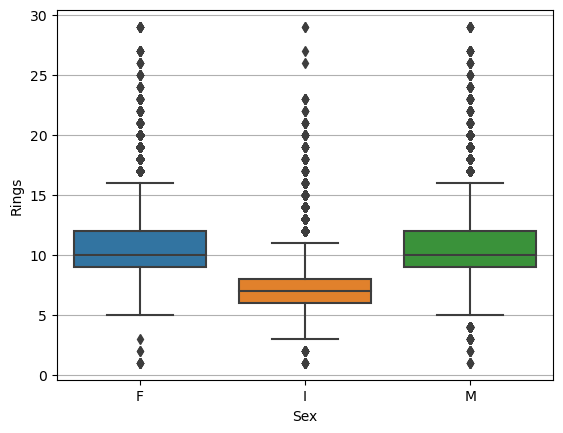

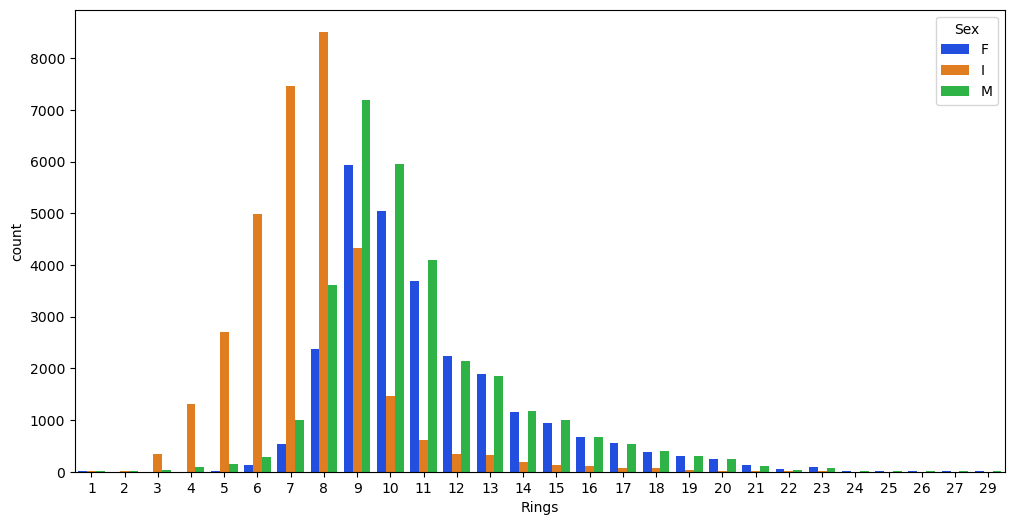

In [333]:
plt.figure()
plt.grid()
sns.boxplot(y = "Rings", x = "Sex", data = df)
plt.show()

plt.figure(figsize=(12,6))
# Créer un graphique de barres empilées pour visualiser la relation entre la survie et la classe
sns.countplot(x="Rings", hue="Sex", data=df, palette ="bright")

# Afficher le graphique
plt.show()

- Variation de la médiane en fonction de la modalité, **on peut s'attendre à ce qu'il existe une dépendance entre les deux variables**
- On va confirmer cela à l'aide d'un test statistique

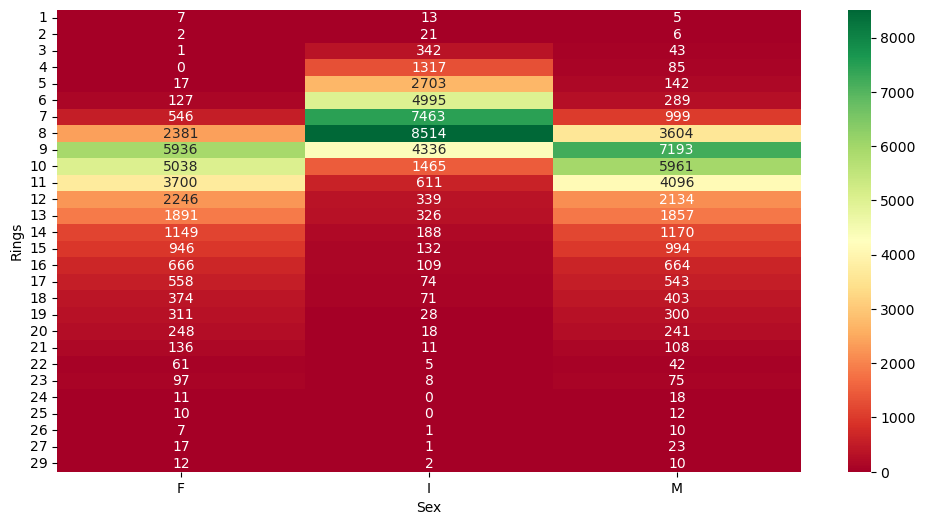

In [423]:
contingency = pd.crosstab(df["Rings"], df["Sex"])
plt.figure(figsize=(12,6))
sns.heatmap(contingency, annot = True, fmt = "d", cmap = "RdYlGn")
plt.show()

La combinaison la plus majoritairement représentée sont les jeunes ormeaux (sex = I) avec 8 anneaux.  On peut voir qu'à partir de 9 anneaux, on retrouve beaucoup d'ormeaux male ou femelles

#### Test kruskal wallis

- Soit H0 l'hypothèse nulle, les variables sont indépendantes (pour ici, signifie que les médianes sont égales)

Si l'hypothèse est vérifiée, alors on peut supprimer la variable (car ca signifierai que peu importe la modalité prise, il n'y aurait pas de variation et donc on peut conclure a une indépendance entre les deux variables

In [270]:
def kruskal_wallis(feature, target, dataframe):
    var_a_conserver = []
    var_a_supprimer = []

    # Test si la feature est une liste ou simplement une feature
    if type(feature) == str:
        feature = [feature]

    for col in feature:
        # Séparer les données en fonction des différentes valeurs prises par la variable qualitatives
        grouped_data = [dataframe.loc[dataframe[target] == category, col] for category in dataframe[target].unique()]

        # Effectuer le test de Kruskal-Wallis
        statistic, p_value = kruskal(*grouped_data)

        # Afficher les résultats
        print(f"Statistique de test : {statistic}")
        print(f"P-value : {p_value}")

        # Interpréter les résultats
        alpha = 0.05  # Niveau de signification
        if p_value < alpha:
            var_a_conserver.append(col)
        else:
            var_a_supprimer.append(col)
        print()

    print("features a supprimer :", var_a_supprimer)
    print("features a conserver :", var_a_conserver)

    return var_a_conserver, var_a_supprimer

In [271]:
kruskal_wallis(var_qual,"Rings",df)

Statistique de test : 171.32367461040846
P-value : 6.191072063352675e-23

features a supprimer : []
features a conserver : ['Sex']


(['Sex'], [])

- on confirme ce qu'on a vu plus haut sur le boxplot, qu'il y a une **dépendance** entre ces deux variables, et donc on **rejette H0**.
-  on conserve la variable Sex dans le jeu de données

### conclusion  pour l'analyse bivariée :
- Toutes les variables ici influence notre target, et semblent etre toutes pertinentes

## 4. Analyse multivariée :
- regardons en fonction du sexe : nb rings, weight/height